In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import optuna

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.linear_model import Lasso, LogisticRegression

import catboost
import xgboost as xgb
from xgboost.callback import EarlyStopping
import lightgbm as lgbm

import os
import sys
import datetime

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)


In [3]:
from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
grn = Style.BRIGHT + Fore.GREEN
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

rc = {
    "axes.facecolor": "#FFFEF8",
    "figure.facecolor": "#FFFEF8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

In [4]:
orig = pd.read_csv(os.path.join(CFG.RAW_DATA, 'Pulsar.csv'))
train = pd.read_csv(os.path.join(CFG.RAW_DATA, 'train.csv')).drop(columns='id')
test = pd.read_csv(os.path.join(CFG.RAW_DATA, 'test.csv')).drop(columns='id')

In [44]:
train = pd.concat([train, orig]).reset_index(drop=True)
def fe(df):
    df['Mean_DMSNR_Skewness_Ratio'] = df['Mean_DMSNR_Curve'] / df['Skewness_DMSNR_Curve']
    df['SD_Integrated_Skewness_Ratio'] = df['SD'] / df['Skewness']
    df['EK_Integrated_SD_Ratio'] = df['EK'] / df['SD']
    return df

train = fe(train)
test = fe(test)

In [5]:
scaler = RobustScaler()

y = train['Class']
X = train.drop(['Class'], axis=1)

XLR = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
testLR = pd.DataFrame(scaler.transform(test), columns=test.columns)

In [6]:
PATIENCE = 100

modelsCB = []
predsCB = []

k_fold = RepeatedStratifiedKFold(n_splits=CFG.NFOLDS, n_repeats=CFG.REPEATS, random_state=CFG.SEED) 

# gpu_params = {'task_type' : "GPU", 'devices' : '0:1'}
cbr_params = {
            'iterations':9999,
            'depth': 3,
            'learning_rate': 0.15687380686250746,
            'l2_leaf_reg': 4.0368544113430485,
            'random_strength': 0.1279482215776108,
            'max_bin': 238,
            'od_wait': 49,
            'one_hot_max_size': 39,
            'grow_policy': 'SymmetricTree',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            
            
            'random_state': CFG.SEED
        }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = catboost.CatBoostClassifier(**cbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose=150,
         )
    modelsCB.append(model)
    predsCB.append(model.predict_proba(test)[:, 1])

0:	learn: 0.3558237	test: 0.3553922	best: 0.3553922 (0)	total: 50.3ms	remaining: 8m 22s
150:	learn: 0.0305019	test: 0.0301277	best: 0.0301241 (147)	total: 724ms	remaining: 47.2s
300:	learn: 0.0286069	test: 0.0297329	best: 0.0297291 (299)	total: 1.39s	remaining: 44.7s
450:	learn: 0.0272858	test: 0.0295660	best: 0.0295295 (443)	total: 1.99s	remaining: 42.1s
600:	learn: 0.0261475	test: 0.0294767	best: 0.0294605 (593)	total: 2.59s	remaining: 40.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.02946004689
bestIteration = 604

Shrink model to first 605 iterations.
0:	learn: 0.3541054	test: 0.3547472	best: 0.3547472 (0)	total: 4.35ms	remaining: 43.5s
150:	learn: 0.0295625	test: 0.0319021	best: 0.0319021 (150)	total: 590ms	remaining: 38.5s
300:	learn: 0.0276047	test: 0.0315304	best: 0.0315175 (297)	total: 1.2s	remaining: 38.5s
450:	learn: 0.0263094	test: 0.0313741	best: 0.0313741 (450)	total: 1.76s	remaining: 37.4s
600:	learn: 0.0251484	test: 0.0312260	best: 0.0312109 (5

In [7]:
def get_fi(model):
    feature_importance =  [model[x].feature_importances_ for x in range(CFG.NFOLDS*CFG.REPEATS)]
    feature_importance = np.average(feature_importance,axis=0)
    feature_df = pd.DataFrame(feature_importance, index=X.columns)

    fig, ax = plt.subplots(figsize=(12, 4))
    sns.barplot(x=feature_df.values.squeeze(), y=feature_df.index,
                color=palette[-3], linestyle="-", width=0.5, errorbar='sd',
                linewidth=0.5, edgecolor="black", ax=ax)
    ax.set_title('Feature Importance', fontdict={'fontweight': 'bold'})
    ax.set(xlabel=None)

    for s in ['right', 'top']:
        ax.spines[s].set_visible(False)

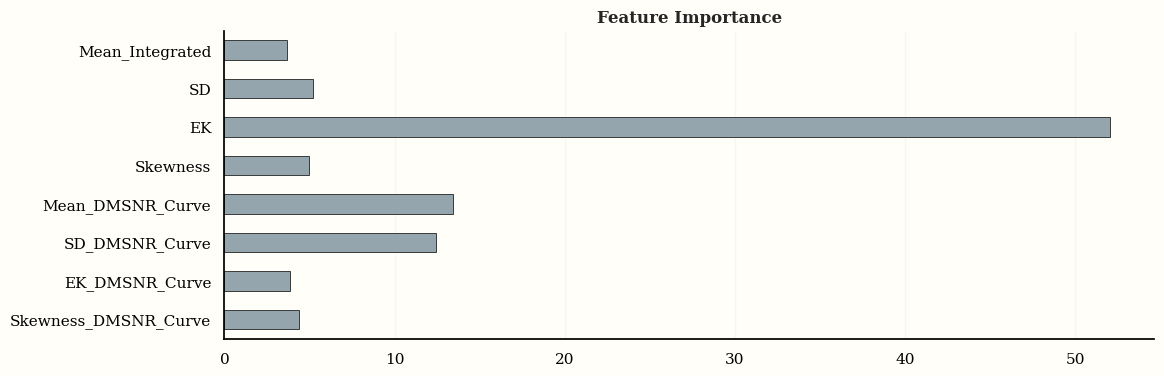

In [8]:
get_fi(modelsCB)

In [9]:
from xgboost import XGBClassifier, XGBRegressor

modelsXB = []
predsXB = []

PATIENCE = 50

gpu_params = {'tree_method' : "gpu_hist", 'gpu_id' : 0}
xgbr_params = {
            'n_estimators':9999,
            'max_depth': 4,
            'learning_rate': 0.05333221939055333,
            'min_child_weight': 4,
            'gamma': 5.301218558776368e-08,
            'subsample': 0.41010429946197946,
            'colsample_bytree': 0.8298539920447499,
            'reg_alpha': 0.000517878113716743,
            'reg_lambda': 0.00030121415155097723,
            'n_jobs': -1,
            'objective': 'binary:logistic',
            'verbosity': 0,
            'eval_metric': 'logloss',
            'random_state': CFG.SEED}

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = XGBClassifier(**xgbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    modelsXB.append(model)
    predsXB.append(model.predict_proba(test)[:, 1])

[0]	validation_0-logloss:0.64292
[100]	validation_0-logloss:0.03170
[200]	validation_0-logloss:0.02937
[300]	validation_0-logloss:0.02899
[400]	validation_0-logloss:0.02885
[500]	validation_0-logloss:0.02882
[529]	validation_0-logloss:0.02880
[0]	validation_0-logloss:0.64300
[100]	validation_0-logloss:0.03313
[200]	validation_0-logloss:0.03148
[300]	validation_0-logloss:0.03136
[311]	validation_0-logloss:0.03132
[0]	validation_0-logloss:0.64293
[100]	validation_0-logloss:0.03500
[200]	validation_0-logloss:0.03307
[263]	validation_0-logloss:0.03309
[0]	validation_0-logloss:0.64290
[100]	validation_0-logloss:0.03235
[200]	validation_0-logloss:0.03032
[300]	validation_0-logloss:0.03007
[332]	validation_0-logloss:0.03008
[0]	validation_0-logloss:0.64293
[100]	validation_0-logloss:0.03359
[200]	validation_0-logloss:0.03198
[268]	validation_0-logloss:0.03197
[0]	validation_0-logloss:0.64298
[100]	validation_0-logloss:0.03401
[200]	validation_0-logloss:0.03215
[300]	validation_0-logloss:0.032

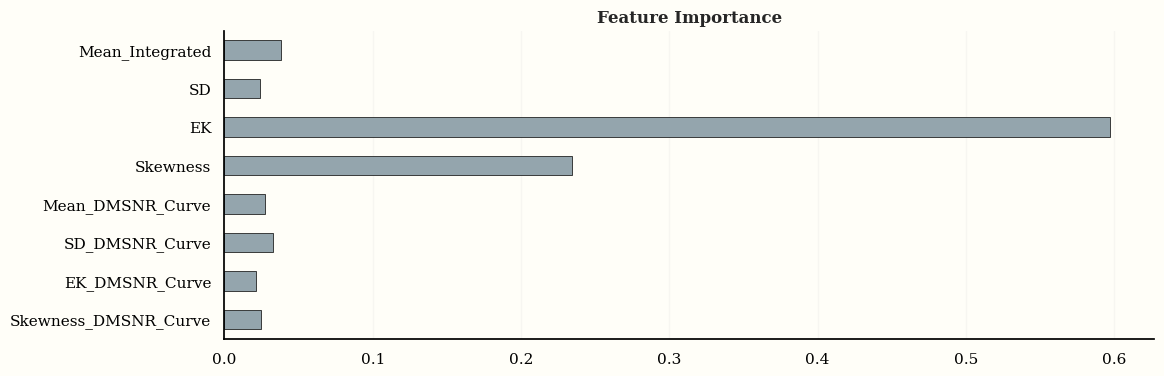

In [10]:
get_fi(modelsXB)

In [11]:
modelsLB = []
predsLB = []

PATIENCE = 50

lgbr_params = {
            'n_estimators': 9999,
            'max_depth': 5,
            'learning_rate': 0.00693702575527996,
            'subsample': 0.20851841295589477,
            'colsample_bytree': 0.5784778854092203,
            'reg_alpha': 0.2622912287429849,
            'reg_lambda': 2.8702494234117617e-08,
            'objective': 'binary',
            'metric': 'logloss',
            'boosting_type': 'gbdt',
           
            'random_state': CFG.SEED
        }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = lgbm.LGBMClassifier(**lgbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          eval_metric = 'logloss',
          early_stopping_rounds = PATIENCE,
          verbose = 150
         )
    modelsLB.append(model)
    predsLB.append(model.predict_proba(test)[:, 1])

[150]	valid_0's binary_logloss: 0.0871371
[300]	valid_0's binary_logloss: 0.0476013
[450]	valid_0's binary_logloss: 0.035694
[600]	valid_0's binary_logloss: 0.03192
[750]	valid_0's binary_logloss: 0.0307187
[900]	valid_0's binary_logloss: 0.0301814
[1050]	valid_0's binary_logloss: 0.0299362
[1200]	valid_0's binary_logloss: 0.0297902
[1350]	valid_0's binary_logloss: 0.0296889
[1500]	valid_0's binary_logloss: 0.029618
[150]	valid_0's binary_logloss: 0.0882383
[300]	valid_0's binary_logloss: 0.0491489
[450]	valid_0's binary_logloss: 0.0374881
[600]	valid_0's binary_logloss: 0.0339206
[750]	valid_0's binary_logloss: 0.0328147
[900]	valid_0's binary_logloss: 0.0325019
[1050]	valid_0's binary_logloss: 0.032363
[1200]	valid_0's binary_logloss: 0.0322973
[1350]	valid_0's binary_logloss: 0.0322484
[1500]	valid_0's binary_logloss: 0.03222
[150]	valid_0's binary_logloss: 0.0881599
[300]	valid_0's binary_logloss: 0.0494941
[450]	valid_0's binary_logloss: 0.0382909
[600]	valid_0's binary_logloss: 0

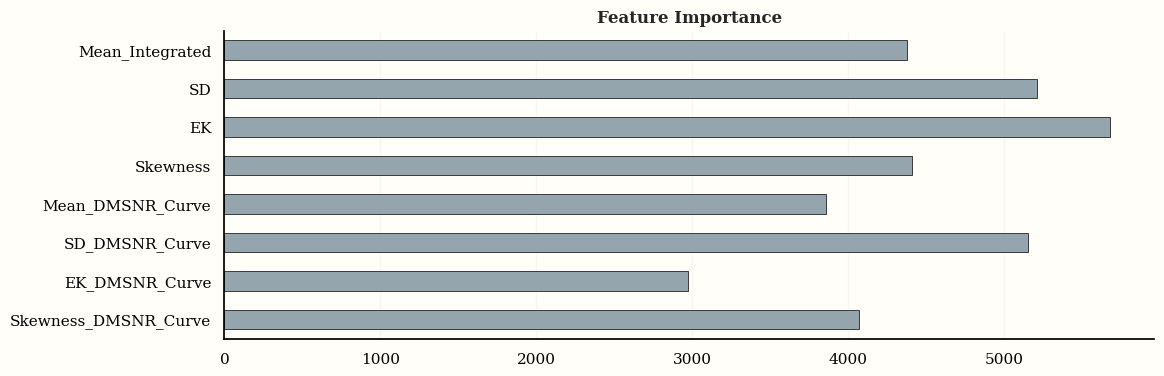

In [12]:
get_fi(modelsLB)

In [58]:
modelsLR = []
predsLR = []
predsLR2 = []

params = {
        'max_iter': 10000,
        'C': 0.1,
        'tol': 0.001029268232213037,
        'n_jobs': -1,
        'random_state': CFG.SEED,
        'verbose': 100
    }

for train_index, test_index in k_fold.split(XLR, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression(**params)
    model.fit(X=X_train, y=y_train)
    ypred = model.predict_proba(X_valid)[:, 1]
    score = log_loss(y_valid, ypred)
    print(f'Score: {score}')
    
    modelsLR.append(model)
    predsLR.append(model.predict_proba(testLR)[:, 1])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.8s finished
Score: 0.056492758532931266
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.1s finished
Score: 0.05627772303481176
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.2s finished
Score: 0.05401251493535325
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.9s finished
Score: 0.05642864341826786
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4

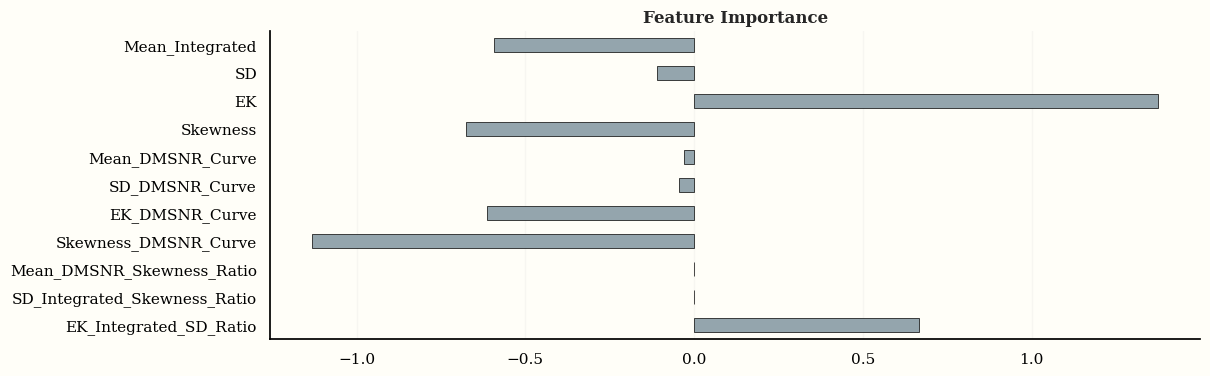

In [38]:
feature_importance =  np.array([modelsLR[x].coef_ for x in range(CFG.NFOLDS*CFG.REPEATS)])
feature_importance = feature_importance.reshape((CFG.NFOLDS*CFG.REPEATS, XLR.shape[1]))
feature_importance = np.average(feature_importance,axis=0)
feature_df = pd.DataFrame(feature_importance, index=X.columns)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x=feature_df.values.squeeze(), y=feature_df.index,
            color=palette[-3], linestyle="-", width=0.5, errorbar='sd',
            linewidth=0.5, edgecolor="black", ax=ax)
ax.set_title('Feature Importance', fontdict={'fontweight': 'bold'})
ax.set(xlabel=None)

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)

In [13]:
def coef_objective(trial):
    a = trial.suggest_float('a', 0, 1)
    b = trial.suggest_float('b', 0.5, 1)
    c = trial.suggest_float('c', 0.5, 1)
    #e = trial.suggest_float('e', 0, 0.1)
    
    preds_eval = []
    for model in modelsCB:
        preds_eval.append(model.predict_proba(X)[:, 1])
    resCB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsXB:
        preds_eval.append(model.predict_proba(X)[:, 1])
    resXB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsLB:
        preds_eval.append(model.predict_proba(X)[:, 1])
    resLB = np.average(np.array(preds_eval),axis=0)
    
    # preds_eval = []
    # for model in modelsLR:
    #     preds_eval.append(model.predict_proba(XLR)[:, 1])
    # resLR = np.average(np.array(preds_eval),axis=0)
    
    res1 =  (resCB * a + resXB * b + resLB * c)/(a + b + c)
    res = log_loss(y, res1)
    return res

study = optuna.create_study(direction= 'minimize')

[I 2023-03-13 15:26:00,406] A new study created in memory with name: no-name-eb866fa1-e7f8-4994-a160-d9321220183c


In [14]:
study.optimize(coef_objective, n_trials=100)
coef_dict = study.best_params
coef_dict

[I 2023-03-13 15:26:26,321] Trial 0 finished with value: 0.02490511989300782 and parameters: {'a': 0.32782140341979515, 'b': 0.79222117306858, 'c': 0.6881703954781205}. Best is trial 0 with value: 0.02490511989300782.
[I 2023-03-13 15:26:42,126] Trial 1 finished with value: 0.025000118561050978 and parameters: {'a': 0.7005591812803637, 'b': 0.8814047232742994, 'c': 0.7733422970126448}. Best is trial 0 with value: 0.02490511989300782.
[I 2023-03-13 15:26:57,670] Trial 2 finished with value: 0.024919663405490212 and parameters: {'a': 0.9860123497531451, 'b': 0.6809944971341754, 'c': 0.9459496577730221}. Best is trial 0 with value: 0.02490511989300782.
[I 2023-03-13 15:27:13,021] Trial 3 finished with value: 0.02497739048456405 and parameters: {'a': 0.008400227529435367, 'b': 0.978392924171857, 'c': 0.6097030208398371}. Best is trial 0 with value: 0.02490511989300782.
[I 2023-03-13 15:27:29,003] Trial 4 finished with value: 0.024771185886399993 and parameters: {'a': 0.5382016531859378, 'b

{'a': 0.0013682907407197736, 'b': 0.501503861612639, 'c': 0.9764370513390045}

In [15]:
coef_dict

{'a': 0.0013682907407197736, 'b': 0.501503861612639, 'c': 0.9764370513390045}

In [16]:
predCB = np.average(np.array(predsCB),axis=0)
predXB = np.average(np.array(predsXB),axis=0)
predLB = np.average(np.array(predsLB),axis=0)

pred = (predCB * coef_dict['a'] + predXB * coef_dict['b'] + predLB * coef_dict['c']) / (coef_dict['a'] + coef_dict['b'] + coef_dict['c'])

In [17]:
submission = pd.read_csv(os.path.join(CFG.DATA_PATH, 'sample_submission.csv'))
submission['Class'] = pred
# submission['Class'] = submission['Class'].clip(0.001, .98)

In [18]:
submission.to_csv(os.path.join(CFG.BASE_PATH, 'submissions', 'CT-XG-LGB-LR_classifiers_normalized_train.csv'), index=False)

In [19]:
submission['Class'].values

array([1.22908827e-04, 1.26806905e-03, 1.48233323e-04, ...,
       1.83770664e-04, 7.21910139e-02, 9.81661188e-01])

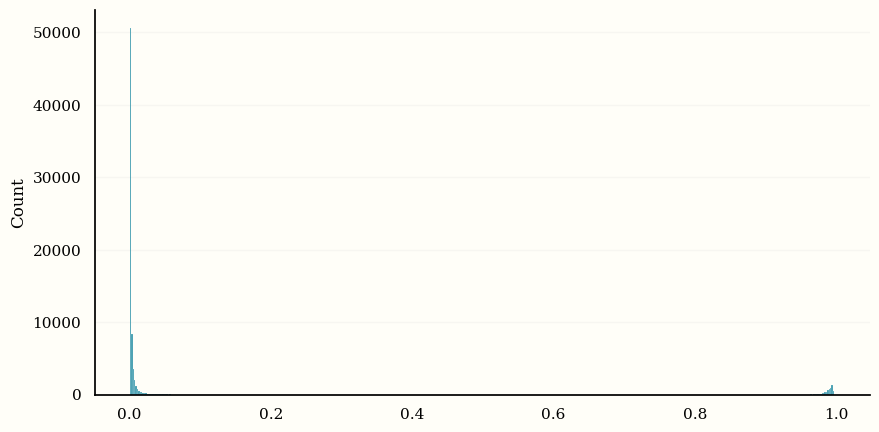

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(pred, bins=500, color=palette[1], ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(False)
ax.yaxis.grid(True)